## Villin Headpiece HP35 with HDBSCAN. Adaptive Sampling.

Here we use the fast folding (Nle/Nle)-mutant of Villin Headpiece HP35, which has been previously discretized by using HDBSCAN, to run adaptive sampling with the following scoring functions: 'counts', 'populations', 'non_detailed_balance', and 'flux'.

The first thing one must do is download the data from [OSF](https://osf.io/gt49w/?view_only=4f16c7c723194a3c806999a6f37ab839) and then import a number of libraries we will need as we run this example, most unusual dependencies are listed in repo's README.

In [1]:
import h5py
import random
import sys
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib as mpl
import scipy.stats as stats
from mpl_toolkits.axes_grid1 import make_axes_locatable

import seaborn as sns
sns.set(style="ticks", color_codes=True, font_scale=1.5)
sns.set_style({"xtick.direction": "in", "ytick.direction": "in"})

In [2]:
from mastermsm.msm import msm
from mastermsm.msm import msm_lib
from mastermsm.trajectory import traj

### Load discretized trajectory

In [3]:
h5file = "./data/c-alpha-and-inverses/lag-tica-5/hdbscan_50_80.h5"
f = h5py.File(h5file, 'r')
data = np.array(f['hdbscan'])
x = list(data)
f.close()

In [4]:
type(x), type(data), len(x), data.shape

(list, numpy.ndarray, 151932, (151932,))

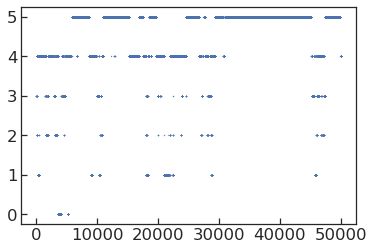

In [5]:
# show how trajectory goes over HDBSCAN clusters
plt.plot(data[:50000], '.', ms=0.5)

### MasterMSM: Obtain the reference MSM for later comparisons

In [6]:
distraj = traj.TimeSeries(distraj=x, dt=1)
distraj.find_keys()
distraj.keys.sort()

In [7]:
msm_villin=msm.SuperMSM([distraj], sym=False) #True

     # states: 6


In [8]:
msm_villin.convergence_test(time=[1, 2, 5, 10, 20, 50, 100, 200], error=True)
#msm_villin.convergence_test(time=[1, 2, 5, 10, 20, 50, 100, 200], error=False)

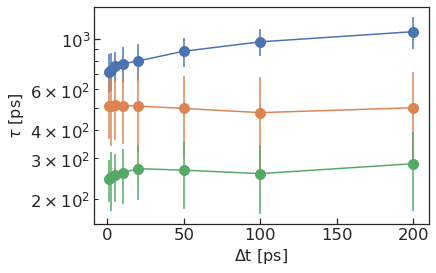

In [10]:
tau0_vs_lagt = np.array([[x,msm_villin.msms[x].tauT[0],msm_villin.msms[x].tau_std[0]] \
               for x in sorted(msm_villin.msms.keys())])
tau1_vs_lagt = np.array([[x,msm_villin.msms[x].tauT[1],msm_villin.msms[x].tau_std[1]] \
               for x in sorted(msm_villin.msms.keys())])
tau2_vs_lagt = np.array([[x,msm_villin.msms[x].tauT[2],msm_villin.msms[x].tau_std[2]] \
               for x in sorted(msm_villin.msms.keys())])
fig, ax = plt.subplots()
ax.errorbar(tau0_vs_lagt[:,0],tau0_vs_lagt[:,1],fmt='o-', yerr=tau0_vs_lagt[:,2], markersize=10)
ax.errorbar(tau1_vs_lagt[:,0],tau1_vs_lagt[:,1],fmt='o-', yerr=tau1_vs_lagt[:,2], markersize=10)
ax.errorbar(tau2_vs_lagt[:,0],tau2_vs_lagt[:,1],fmt='o-', yerr=tau2_vs_lagt[:,2], markersize=10)
ax.set_xlabel(r'$\Delta$t [ps]', fontsize=16), ax.set_ylabel(r'$\tau$ [ps]', fontsize=16)
_ = ax.set_yscale('log') #_ = ax.set_xscale('log')

In [11]:
# lag time selection after convergence test
lt = 100

In [12]:
#for lt in lagt:
msm_villin.do_msm(lt)
msm_villin.msms[lt].do_trans(evecs=True)

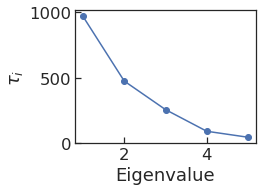

In [14]:
fig, ax = plt.subplots(figsize=(4,3))
ax.plot(range(1,len(msm_villin.msms[lt].tauT[:10])+1),msm_villin.msms[lt].tauT[:10],'-o')
ax.set_xlabel('Eigenvalue'), ax.set_ylabel(r'$\tau_i$')#, ax.set_yscale('log')
plt.tight_layout()

### Define routines for metrics

In [16]:
def msmpop(MSMp,MSMq,tr):
    mat = np.zeros((len(MSMp.trans[:,0]),len(MSMp.trans[:,0])))
    mat = mat + 1./float(len(tr.distraj))
    for i in MSMq.keep_keys:
        for j in MSMq.keep_keys:
            iq,jq = MSMq.keep_keys.index(i), MSMq.keep_keys.index(j)
            ip,jp = MSMp.keep_keys.index(i), MSMp.keep_keys.index(j)
            mat[ip,jp] = mat[ip,jp] + MSMq.trans[iq,jq]
    
    auxmsm = msm.MSM(keys=MSMp.keys, lagt=MSMp.lagt, sym=MSMp.sym) #keys=MSMp.keep_keys
    auxmsm.trans, auxmsm.keep_states = mat, MSMp.keep_states
    tauT, peqT = auxmsm.calc_eigsT()
    
    score = 0.0
    for p,pq in zip(MSMp.peqT,peqT):
        score += ((pq - p)*(pq - p))#/p since p is used as weight
    
    return score #*100.

In [17]:
def relative_entropy_bowman(MSMp, matq, printmat=False):
    """ 
    Calculates relative entropy between reference (MSMp) and test (MSMq)
    using equilibrium probabilities as weights.
    Bowman et al. (JCTC, 2010; PNAS 2010)
    
    """
    mat = np.zeros((len(MSMp.trans[:,0]), len(MSMp.trans[:,0])))
    for i in MSMp.keep_keys:
        for j in MSMp.keep_keys:
            ip, jp = MSMp.keep_keys.index(i), MSMp.keep_keys.index(j)
            if MSMp.trans[ip,jp] and matq[ip,jp]:
                aux = np.log(MSMp.trans[ip,jp]/matq[ip,jp])
                mat[ip,jp] = MSMp.peqT[ip]*MSMp.trans[ip,jp]*aux
            else:
                mat[ip,jp] = 0 
    entropy = np.sum(mat[mat!=0])
    if printmat: 
        return entropy, mat
    return entropy

In [18]:
def relative_entropy(MSMp, matq, printmat=False):
    """ 
    Calculates relative entropy between reference (MSMp) and test (MSMq)
    Bowman, Ensign and Pande (JCTC, 2010)
    
    """
    mat = np.zeros((len(MSMp.trans[:,0]), len(MSMp.trans[:,0])))
    for i in MSMp.keep_keys:
        for j in MSMp.keep_keys:
            ip, jp = MSMp.keep_keys.index(i), MSMp.keep_keys.index(j)
            if MSMp.trans[ip,jp] and matq[ip,jp]:
                aux = np.log(MSMp.trans[ip,jp]/matq[ip,jp])
                mat[ip,jp] = MSMp.trans[ip,jp]*aux
            else:
                mat[ip,jp] = 0 
    entropy = np.sum(mat[mat!=0])
    if printmat: 
        return entropy, mat
    return entropy

In [19]:
def pseudo(MSMp, MSMq, tr):
    mat = np.zeros((len(MSMp.keys),len(MSMp.keys)))
    mat = mat + 1./float(len(tr.distraj))
    for i in MSMq.keys:
        for j in MSMq.keys:
            iq,jq = MSMq.keys.index(i), MSMq.keys.index(j)
            ip,jp = MSMp.keys.index(i), MSMp.keys.index(j)
            if mat[ip,jp] and MSMq.count[iq,jq]:
                mat[ip,jp] = mat[ip,jp] + MSMq.count[iq,jq]
            else:
                mat[ip,jp] = 0.
    trans = msm_lib.calc_trans(nkeep=len(MSMp.keep_states), \
            keep_states=MSMp.keep_states, count=mat, normalize=False)
    return trans

In [20]:
def sortkeys(MSMp,MSMq,tr, evecs=True):
    mat = np.zeros((len(MSMp.keys),len(MSMp.keys)))
    #mat = MSMp.count
    mat = mat + 1./float(len(tr.distraj))
    for i in MSMq.keys:
        for j in MSMq.keys:
            iq,jq = MSMq.keys.index(i), MSMq.keys.index(j)
            ip,jp = MSMp.keys.index(i), MSMp.keys.index(j)
            if mat[ip,jp] and MSMq.count[iq,jq]:
                mat[ip,jp] = mat[ip,jp] + MSMq.count[iq,jq]
            else:
                mat[ip,jp] = 0.
    trans = msm_lib.calc_trans(nkeep=len(MSMp.keep_states), \
                keep_states=MSMp.keep_states, count=mat, normalize=False)
    if evecs is False: return trans
    
    #rvecsT, lvecsT = msm.calc_eigsT(evecs=True)
    auxmsm = msm.MSM(keys=MSMp.keys, lagt=MSMp.lagt, sym=MSMp.sym) #keys=MSMp.keep_keys
    auxmsm.trans, auxmsm.keep_states = trans, MSMp.keep_states
    tauT, peqT, rvecsT, lvecsT = \
                auxmsm.calc_eigsT(evecs=True)
    return trans, rvecsT

### Define routines for adaptive sampling

In [21]:
class adaptive_sampling(object):

    def __init__(self, reftraj=None, keys=None):
        
        self.reftraj, self.keys = reftraj, keys
        # initialize other classes
        self.resampler = resampler()
        self.msm = MSM()
        
           
    def guess(self, reftraj, keys, n_runs=10, random_inputs=True):
        
        self.reftraj, self.keys = reftraj, keys
        self.n_runs = n_runs
        
        tr = traj.TimeSeries(distraj=reftraj)
        tr.find_keys(), tr.keys.sort()
        state_kv, inputs = {}, []
        n_msm_runs = np.random.choice(range(len(keys)), n_runs)
        print('guess inputs:', n_msm_runs)
        for n in n_msm_runs:
            if n not in state_kv.keys():
                gen_dict_state([tr], keys, n, state_kv)
            try:
                frame, which_tr = random.choice(state_kv[n])
                inputs.append([frame, keys[n]])
            except IndexError:
                print('Error in gen_input, check n_msm_runs and MSM.keys')
    
        self.resampler.state_kv = state_kv
        self.resampler.inputs = inputs
        if not random_inputs:
            inputs = []
            [inputs.append([0,0]) for x in range(n_runs)]
            self.resampler.inputs = inputs
        
    
    def run(self, n_runs=10, n_epochs=10, nsteps=100, \
            lagt=10, scoring='counts', inputs=None, sym=False):
        
        if inputs is None and self.resampler.inputs is None:
            self.guess(self.reftraj, self.keys, n_runs=n_runs)
        elif inputs is not None:
            self.n_runs = len(inputs)
            self.resampler.inputs = inputs
            self.resampler.state_kv = {}
        
        self.msmepoch, self.inpepoch, self.trajfiles, n = [], [], {}, 0
        self.resampler.reftraj = self.reftraj
        
        self.chis = []
        while True:
            if n > n_epochs: break
            print('Epoch nº:',n)
            self.trajfiles[n] = self.resampler.resampler(self.reftraj, nsteps)
            self.msm.build_msm(self.trajfiles, lagt, sym)
            self.msmepoch.append(self.msm.msm)
            self.chis.append(self.chi2(self.msm.msm.count))
            self.resampler.scorer(self.msm.trs, self.msm.msm, self.n_runs, scoring, sym)
            self.inpepoch.append(self.resampler.inputs)
            n += 1
            
    def chi2(self, counts):
        norm, chi = 0.0, 0.0
        for i in range(len(counts)):
            norm += counts[i,i]*counts[i,i]
            for j in range(i):
                chi += (counts[i,j]-counts[j,i])*(counts[i,j]-counts[j,i])
                norm += counts[i,j]*counts[i,j]
                norm += counts[j,i]*counts[j,i]
        return chi

In [22]:
class resampler(object):
    
    def __init__(self, inputs=None, reftraj=None):
        
        self.inputs = inputs
        self.reftraj = reftraj
        self.state_kv = {}
    
    def resampler(self, reftraj, nsteps):
        
        trajfiles = []
        for inp in self.inputs:
            #print(nsteps,inp)
            data = reftraj[inp[0]:inp[0]+nsteps]
            trajfiles.append(data)

        return trajfiles
    
    
    def scorer(self, trs, mmsm, n_runs, scoring, sym):
    
        if scoring == "counts":
            states = counts(mmsm)
            #states = states.real
        elif scoring == "populations":
            states = populs(mmsm)
            #states = states.real
        elif scoring == "non_detailed_balance":
            if sym:
                raise Exception("Cannot impose symmetry with chosen scoring criteria.")
            states = non_detbal(mmsm)
        elif scoring == "flux":
            if sym:
                raise Exception("Cannot impose symmetry with chosen scoring criteria.")
            states = flux_inbalance(mmsm)
        else:
            sys.exit(" Please select one correct scoring.")

        self.inputs = self.gen_input(states, trs, mmsm.keys, mmsm.keep_states, n_runs, scoring)


    def gen_input(self, states, trs, keys, keep_states, n_runs, scoring):

        print('gen_input states:',states)
        if scoring == 'populations':
            n_msm_runs = np.random.choice(range(len(keep_states)), n_runs, p=states)
            aux = keep_states
        else:
            n_msm_runs = np.random.choice(range(len(keys)), n_runs, p=states)
            aux = keys

        tr = traj.TimeSeries(distraj=self.reftraj)
        tr.find_keys(), tr.keys.sort()
        #state_kv, inputs = {}, []
        inputs = []
        for n in n_msm_runs:
            if n not in self.state_kv.keys():
                #gen_dict_state(trs, aux, n, state_kv)
                gen_dict_state([tr], aux, n, self.state_kv)
            try:
                frame, which_tr = random.choice(self.state_kv[n])
                # 'n' stands for the index corresponding to a label
                inputs.append([frame, aux[n]])
            except IndexError:
                print('Error in gen_input, check n_msm_runs and MSM.keys')
    
        return inputs

In [23]:
def counts(mmsm):
    p = [(0.5/np.sum(mmsm.count[x, :]) + 0.5/np.sum(mmsm.count[:, x])) \
        if (np.sum(mmsm.count[x, x]) != 0) \
        else 0                        \
        for x in range(len(mmsm.keys))]
    if np.sum(p) == 0:
        sys.exit(" Error in 'resampler'. Please choose another 'scoring' option")
    return p/np.sum(p)

def populs(mmsm):
    #p = np.nan_to_num(1./mmsm.peqT, nan=0.0)
    p = [1./mmsm.peqT[i] if np.isreal(mmsm.peqT[i]) and \
         not np.isnan(mmsm.peqT[i]) else 0.0 for i in range(len(mmsm.keep_states))]
    return p/np.sum(p)

def non_detbal(mmsm):
    total = mmsm.count + np.transpose(mmsm.count)
    nondb = abs(mmsm.count - np.transpose(mmsm.count))/total
    nondb = np.sum(np.nan_to_num(nondb, nan=0.0), axis=1)
    states = [nondb[i] for i in range(len(mmsm.keys))]
    return states/np.sum(states)

def flux_inbalance(mmsm):
    flux = [(abs(np.sum(mmsm.count[x,:]) - np.sum(mmsm.count[:,x]))/\
    (np.sum(mmsm.count[:,x]) + np.sum(mmsm.count[x,:]))) \
    if (np.sum(mmsm.count[:,x]) + np.sum(mmsm.count[x,:])) >= 1
    else 0 \
    for x in range(len(mmsm.keys))]
    #this is done by above abs: flux += np.min(flux)
    if np.sum(flux) == 0:
        sys.exit(" Error in 'resampler'. Please choose another 'scoring' option")
    return flux/np.sum(flux)

In [24]:
def gen_dict_state(trs, keys, s, state_kv):
    state_kv[s] = []
    n = 0
    for t in trs:
        n +=1
        try:
            ivals = list_duplicates_of(t.distraj, keys[s])
            for i in ivals:
                state_kv[s].append([i, n-1])
        except KeyError:
            pass

In [25]:
def list_duplicates_of(seq,item):
    start_at = -1
    locs = []
    while True:
        try:
            loc = seq.index(item,start_at+1)
        except ValueError:
            break
        else:
            locs.append(loc)
            start_at = loc
    return locs

In [26]:
class MSM(object):
    
    def __init__(self, trs=None, msm=None):
        
        self.trs, self.msm = trs, msm
    

    def build_msm(self, trajfiles, lagt, sym):
    
        trs = []
        for epoch in trajfiles.values():
            for data in epoch:
                tr = traj.TimeSeries(distraj=data) #, dt=dt
                tr.find_keys(), tr.keys.sort()
                trs.append(tr)
    
        # Invoke SuperMSM to collect keys from all trajectories
        smsm = msm.SuperMSM(trs, sym=sym)
        mymsm = msm.MSM(data=trs, keys=smsm.keys, lagt=lagt, sym=sym)
        mymsm.do_count()
        mymsm.do_trans(evecs=True)
        
        self.trs, self.msm = trs, mymsm

## Adaptive sampling vs. Plain MD

Any adaptive sampling algorithm should improve molecular dynamics calculations with the same amount of cumulative simulation data, so below we compare both of them. Plots similar to the ones used by Hruska et al. JCTC 2020 are employed.

In [27]:
n_epochs, n_runs = 10, 30
lt

100

In [28]:
aux = {}
mychis = []
for nts in np.arange(200,700,200):
    aux[nts] = []
    for i in range(10):
        test = adaptive_sampling()
        test.guess(x, msm_villin.msms[lt].keys, \
                   n_runs=n_runs, random_inputs=True)
        test.run(nsteps=nts, lagt=lt, scoring='non_detailed_balance',\
                n_epochs=n_epochs, sym=False, n_runs=n_runs)
        aux[nts].append(test.msmepoch)


guess inputs: [3 2 3 1 0 5 5 3 4 1 1 5 4 4 4 2 4 5 4 0 3 4 1 3 0 5 0 3 0 1]
Epoch nº: 0
     # states: 6
gen_input states: [0.22569198 0.16926899 0.33073101 0.1238467  0.07523066 0.07523066]
Epoch nº: 1
     # states: 6
gen_input states: [0.216402   0.14293075 0.31035936 0.08031772 0.16666011 0.08333006]
Epoch nº: 2
     # states: 6
gen_input states: [0.258464   0.15725859 0.28423869 0.08597912 0.12038203 0.09367757]
Epoch nº: 3
     # states: 6
gen_input states: [0.22849359 0.16961497 0.29167589 0.069342   0.14819369 0.09267986]
Epoch nº: 4
     # states: 6
gen_input states: [0.19237761 0.16221937 0.29941514 0.09176324 0.14585437 0.10837027]
Epoch nº: 5
     # states: 6
gen_input states: [0.20126628 0.13164988 0.31640278 0.05612801 0.16899168 0.12556138]
Epoch nº: 6
     # states: 6
gen_input states: [0.19494979 0.14129805 0.32120111 0.04007386 0.1769482  0.12552899]
Epoch nº: 7
     # states: 6
gen_input states: [0.21006862 0.14480002 0.31205289 0.03822851 0.18432875 0.1105212 ]
Epoc

gen_input states: [0.22159387 0.17808274 0.26430213 0.09135408 0.15010256 0.09456462]
Epoch nº: 2
     # states: 6
gen_input states: [0.18057206 0.2285722  0.22640895 0.07283035 0.13271339 0.15890305]
Epoch nº: 3
     # states: 6
gen_input states: [0.17532566 0.22985143 0.22507462 0.0648081  0.13877697 0.16616322]
Epoch nº: 4
     # states: 6
gen_input states: [0.17766196 0.21854592 0.23889491 0.05832816 0.13707357 0.16949547]
Epoch nº: 5
     # states: 6
gen_input states: [0.11789981 0.21682025 0.28717291 0.07169803 0.15853053 0.14787848]
Epoch nº: 6
     # states: 6
gen_input states: [0.11726028 0.22298641 0.29401287 0.06971177 0.15657563 0.13945304]
Epoch nº: 7
     # states: 6
gen_input states: [0.11585077 0.22044042 0.29008636 0.07714579 0.15532281 0.14115385]
Epoch nº: 8
     # states: 6
gen_input states: [0.09676478 0.22508449 0.28911327 0.08040965 0.16109395 0.14753385]
Epoch nº: 9
     # states: 6
gen_input states: [0.10661265 0.23583349 0.27864309 0.08199053 0.15896068 0.1379

gen_input states: [0.1010638  0.17570203 0.24040652 0.201335   0.08674423 0.19474842]
Epoch nº: 4
     # states: 6
gen_input states: [0.09993892 0.18573953 0.23878168 0.19171037 0.08292064 0.20090886]
Epoch nº: 5
     # states: 6
gen_input states: [0.08896534 0.1816811  0.22016274 0.20997356 0.09218389 0.20703337]
Epoch nº: 6
     # states: 6
gen_input states: [0.08358436 0.18487279 0.22490041 0.20361328 0.09275169 0.21027747]
Epoch nº: 7
     # states: 6
gen_input states: [0.07472708 0.19205099 0.22673176 0.20409347 0.09280326 0.20959344]
Epoch nº: 8
     # states: 6
gen_input states: [0.07548307 0.18629634 0.23003377 0.2002599  0.09404024 0.21388668]
Epoch nº: 9
     # states: 6
gen_input states: [0.0762104  0.18925575 0.22777645 0.20105139 0.08760011 0.21810589]
Epoch nº: 10
     # states: 6
gen_input states: [0.07282952 0.19148831 0.23365485 0.19339989 0.08906485 0.21956258]
guess inputs: [2 5 2 5 3 4 5 1 2 4 0 5 2 2 4 5 4 5 1 5 4 4 0 2 4 0 5 1 1 4]
Epoch nº: 0
     # states: 6
gen

gen_input states: [0.16019686 0.24690929 0.17880539 0.13944037 0.20978876 0.06485934]
Epoch nº: 6
     # states: 6
gen_input states: [0.16437372 0.24243148 0.18600236 0.13319311 0.20931444 0.0646849 ]
Epoch nº: 7
     # states: 6
gen_input states: [0.17289323 0.23228317 0.18991046 0.13781431 0.21193717 0.05516166]
Epoch nº: 8
     # states: 6
gen_input states: [0.16983554 0.23062735 0.1943965  0.13576383 0.20933844 0.06003834]
Epoch nº: 9
     # states: 6
gen_input states: [0.164219   0.22618295 0.19282646 0.14104827 0.21023513 0.06548819]
Epoch nº: 10
     # states: 6
gen_input states: [0.166485   0.21946211 0.19726448 0.13904514 0.20889281 0.06885046]
guess inputs: [0 5 1 0 2 3 3 4 1 4 1 1 4 5 3 3 5 1 2 4 3 2 5 1 3 0 2 0 2 3]
Epoch nº: 0
     # states: 6
gen_input states: [0.22734691 0.30073052 0.21235625 0.0481044  0.0732663  0.13819563]
Epoch nº: 1
     # states: 6
gen_input states: [0.22206106 0.22599479 0.24021549 0.0281358  0.14286374 0.14072913]
Epoch nº: 2
     # states: 6
gen

gen_input states: [0.07915727 0.16711003 0.24273071 0.17128247 0.22196312 0.1177564 ]
Epoch nº: 8
     # states: 6
gen_input states: [0.08378575 0.16911787 0.23873591 0.17287699 0.2247212  0.11076227]
Epoch nº: 9
     # states: 6
gen_input states: [0.07776922 0.17601194 0.23262021 0.17926964 0.22318175 0.11114723]
Epoch nº: 10
     # states: 6
gen_input states: [0.07403808 0.17901396 0.23117433 0.17996774 0.22550205 0.11030383]
guess inputs: [5 4 1 0 0 2 2 3 3 2 4 3 0 3 4 2 3 1 4 2 3 5 5 2 0 5 4 3 3 2]
Epoch nº: 0
     # states: 6
gen_input states: [0.25585694 0.14669245 0.09823241 0.24247442 0.02232898 0.2344148 ]
Epoch nº: 1
     # states: 6
gen_input states: [0.25073671 0.14847146 0.07982991 0.24056035 0.03121812 0.24918345]
Epoch nº: 2
     # states: 6
gen_input states: [0.20766584 0.12969756 0.07609964 0.18672506 0.12023629 0.27957561]
Epoch nº: 3
     # states: 6
gen_input states: [0.2056163  0.12590505 0.07587197 0.18631949 0.11984686 0.28644033]
Epoch nº: 4
     # states: 6
gen

In [29]:
def pseudo(MSMp, MSMq, tr):
        
    mat = np.zeros((len(MSMp.keep_keys),len(MSMp.keep_keys)))
    mat = mat + 1./float(len(tr.distraj))
    for i in MSMq.keys:
        for j in MSMq.keys:
            iq,jq = MSMq.keys.index(i), MSMq.keys.index(j)
            ip,jp = MSMp.keys.index(i), MSMp.keys.index(j)
            if mat[ip,jp] and MSMq.count[iq,jq]:
                mat[ip,jp] = mat[ip,jp] + MSMq.count[iq,jq]
            else:
                mat[ip,jp] = 0.
    trans = msm_lib.calc_trans(nkeep=len(MSMp.keep_states), \
            keep_states=MSMp.keep_states, count=mat, normalize=False)
    return trans

In [33]:
matent, mattim = np.zeros((n_epochs,len(np.arange(200,700,200))), float), np.zeros((n_epochs,len(np.arange(200,700,200))), float)
matmpop, matpop = np.zeros((n_epochs,len(np.arange(200,700,200))), float), np.zeros((n_epochs,len(np.arange(200,700,200))), float)
ent = []
pop, mpop, tim = [], [], []
for ints, nts in enumerate(np.arange(200,700,200)):
    epochs = []
    for i in range(n_epochs):
        epochs.append([row[i] for row in aux[nts]])
    
    for nep,msmepo in enumerate(epochs):
        auxent, auxtim, auxmpop, auxpop = [], [], [], []
        for i in range(10):
            # metric 1
            
            #COUNT MATRIX (MAT) IS ZERO!!! SHOULD BE AVOIDED BY TARJAN
            # maybe since in calc_trans count[keep_staes[i],keep_staes[j]]
            # is done, do not call it with keep_states=MSMp.keep_states
            
            #qmat = pseudo(msm_villin.msms[lt], msmepo[i], distraj)
            #auxent.append(relative_entropy(msm_villin.msms[lt], qmat))
            
            # metric 2
            score = 0.0
            for tref,t in zip(msm_villin.msms[lt].tauT[:5],msmepo[i].tauT[:5]):
                score += ((t-tref)*(t-tref))/tref #score += np.absolute(t - tref)
            auxtim.append(score)
            
            # metric 3
            auxpop.append(np.absolute(float(len(msmepo[i].keep_states))/ \
                    float(len(msm_villin.msms[lt].keep_states)))*100.)
            
            # metric 4
            auxmpop.append(msmpop(msm_villin.msms[lt], msmepo[i], distraj))
       
        ent.append([nep*n_runs+n_runs, nts, np.mean(auxent)])
        matent[nep, ints] = np.mean(auxent)
        
        tim.append([nep*n_runs+n_runs, nts, np.mean(auxtim)])
        mattim[nep, ints] = np.mean(auxtim)
        
        mpop.append([nep*n_runs+n_runs, nts, np.mean(auxmpop)])
        matmpop[nep, ints] = np.mean(auxmpop)
        
        pop.append([nep*n_runs+n_runs, nts, np.mean(auxpop)])
        matpop[nep, ints] = np.mean(auxpop)

In [34]:
#pop
list(aux.keys())[1]

400

In [35]:
plottime = [row[0]*row[1] for row in pop]
plotexp, plotmpop, plottim  = [row[2] for row in pop], [row[2] for row in mpop], [row[2] for row in tim]
print(plottime)

[6000, 12000, 18000, 24000, 30000, 36000, 42000, 48000, 54000, 60000, 12000, 24000, 36000, 48000, 60000, 72000, 84000, 96000, 108000, 120000, 18000, 36000, 54000, 72000, 90000, 108000, 126000, 144000, 162000, 180000]


In [36]:
# Build fractions of PLAIN MD
rmats = {}
#ldata = np.unique(plottime)
ldata = np.arange(200,700,200)
for plains in ldata:
    rmats[plains] = []
    for epo in range(n_epochs):
        alltime = plains*(epo+1)*n_runs
        plaindistraj = traj.TimeSeries(distraj=x[:alltime], dt=1)
        plaindistraj.find_keys()
        plaindistraj.keys.sort()
        plainmsm = msm.SuperMSM([plaindistraj], sym=False)
        plainmsm.do_msm(lt)
        plainaux = plainmsm.msms[lt]
    #aux.count = aux.count + 1./float(len(plaindistraj.distraj))
        plainaux.do_trans(evecs=False)
        rmats[plains].append(plainaux)

     # states: 6
     # states: 6
     # states: 6
     # states: 6
     # states: 6
     # states: 6
     # states: 6
     # states: 6
     # states: 6
     # states: 6
     # states: 6
     # states: 6
     # states: 6
     # states: 6
     # states: 6
     # states: 6
     # states: 6
     # states: 6
     # states: 6
     # states: 6
     # states: 6
     # states: 6
     # states: 6
     # states: 6
     # states: 6
     # states: 6
     # states: 6
     # states: 6
     # states: 6
     # states: 6


In [37]:
rmats.keys()

dict_keys([200, 400, 600])

In [38]:
mdtim, mdmpop, mdexp = {}, {}, {}
ldata = np.arange(200,700,200)
for plains in ldata:
    mdtim[plains], mdexp[plains], mdmpop[plains] = [], [], []
    for epo in range(n_epochs):
        mdexp[plains].append(np.absolute(float(len(rmats[plains][epo].keep_states))/ \
            float(len(msm_villin.msms[lt].keep_states)))*100.)
        mdmpop[plains].append(msmpop(msm_villin.msms[lt], rmats[plains][epo], distraj))        
        score = 0.0
        for tref,t in zip(msm_villin.msms[lt].tauT[:5],rmats[plains][epo].tauT[:5]):
            score += ((t-tref)*(t-tref))/tref #score += np.absolute(t - tref)
        mdtim[plains].append(score)

In [39]:
listnow = [plottime[i*n_epochs:i*n_epochs+n_epochs] for i in range(1)]
for plains in [200]:
    for epo in range(n_epochs):
        alltime = plains*(epo+1)*n_runs
        print(alltime)
print(listnow)

6000
12000
18000
24000
30000
36000
42000
48000
54000
60000
[[6000, 12000, 18000, 24000, 30000, 36000, 42000, 48000, 54000, 60000]]


Plot % of explored states

(Text(0.5, 0, 'total steps'), Text(0, 0.5, '% explored pop NONDB'))

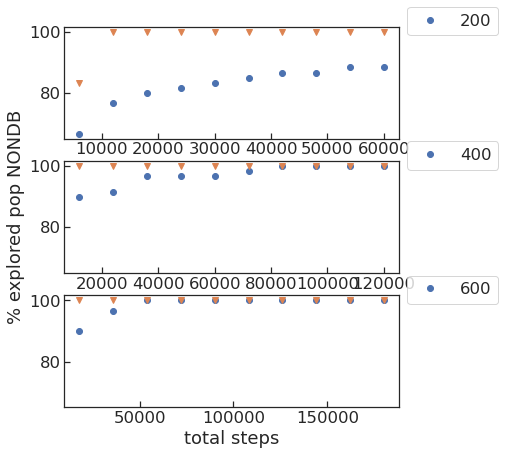

In [43]:
fig, ax = plt.subplots(3,figsize=(6,7),sharey=True )
for i in range(3):
    ax[i].plot(plottime[i*n_epochs:i*n_epochs+n_epochs], \
               plotexp[i*n_epochs:i*n_epochs+n_epochs],'o',label=list(aux.keys())[i])
    ax[i].legend(bbox_to_anchor=(1., 1.25))
    ax[i].plot(plottime[i*n_epochs:i*n_epochs+n_epochs],mdexp[list(aux.keys())[i]],'v')
ax[-1].set_xlabel('total steps'),ax[1].set_ylabel('% explored pop NONDB')

Plot difference in MSM populations

(Text(0.5, 0, 'total steps'), Text(0, 0.5, 'MSM pops - NONDB'))

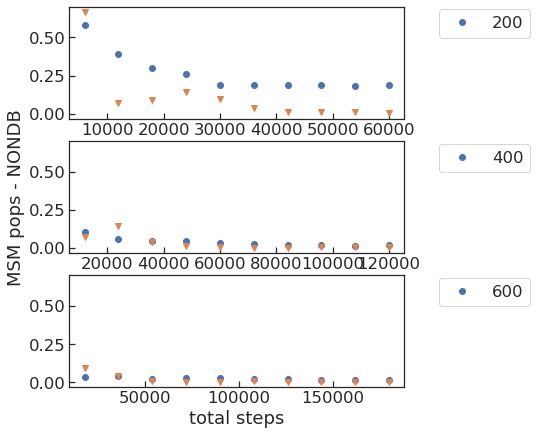

In [44]:
fig, ax = plt.subplots(3,figsize=(6,7),sharey=True )
for i in range(3):
    ax[i].plot(plottime[i*n_epochs:i*n_epochs+n_epochs], \
               plotmpop[i*n_epochs:i*n_epochs+n_epochs],'o',label=list(aux.keys())[i])
    ax[i].legend(bbox_to_anchor=(1.4, 1.05))
    ax[i].plot(plottime[i*n_epochs:i*n_epochs+n_epochs],mdmpop[list(aux.keys())[i]],'v')
ax[-1].set_xlabel('total steps'),ax[1].set_ylabel('MSM pops - NONDB')

Plot difference in relaxation times

(Text(0.5, 0, 'total steps'), Text(0, 0.5, '% relax times - NONDB'))

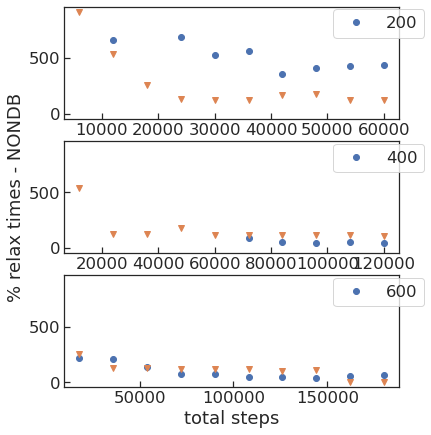

In [45]:
fig, ax = plt.subplots(3,figsize=(6,7),sharey=True )
for i in range(3):
    ax[i].plot(plottime[i*n_epochs:i*n_epochs+n_epochs], \
               plottim[i*n_epochs:i*n_epochs+n_epochs],'o',label=list(aux.keys())[i])
    ax[i].legend(bbox_to_anchor=(1.1, 1.05))
    ax[i].plot(plottime[i*n_epochs:i*n_epochs+n_epochs],mdtim[list(aux.keys())[i]],'v')
ax[-1].set_xlabel('total steps'),ax[1].set_ylabel('% relax times - NONDB')